# This notebook shows the full spatial optimization pipeline. Starting with hypercube construction, MSFA sampling, demosaicing, and finally conversion to RGB true color.

In [1]:
%pylab inline
from scipy.signal import convolve2d
import pandas as pd
from itertools import permutations 

from pysptools import abundance_maps
import numpy
from random import sample as randsamp
import random
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


# Start loading data

In [2]:
dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()

try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

    

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T


# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

In [3]:
spectra.shape

(3, 156)

In [15]:
opti_wavelength = [528, 684, 760]

In [16]:
opti_bw = [20,20,20]

In [17]:
transmissivity = [1,1,1]

In [18]:
pattern_dims = (2,2)

In [19]:
verbose=True

Intensiy

In [20]:
def intensity_rank( hypercube,opti_bw, opti_wavelength, wavelength,transmissivity, verbose=False):
    
    '''
    Inputs:
        1) hypercube (N X M x Q) - 3D synthetic hypercube.
        2) bandwidth
        3) wavelength
        4) transmissivity 
  
    
        ranking depends on three factor: 
        1) Total area of each filter 
        2) The total intensity recieved by this chanel 
        
    Output:
         a matrix with wavelength, bandwidth, intensity recieved
         
    Could be improve:
       ranking way
        
    '''
    
    # preparation
    filter_number = len(opti_wavelength)
    N,M,Q = hypercube.shape
    hypercube = hypercube.reshape(N*M,Q)
    print('hypercube shape',hypercube.shape)
    Intensity_recieved = zeros((N*M,Q))
    #number_of_filter 
    
    L = len(opti_wavelength)
    print(L)
    filters = []
    
    #matrxi for wavelength and bw, intensity, ranked by intensity
    matrix = zeros((L,3))
    matrix[:,0] = np.array(opti_wavelength)
    matrix[:,1] = np.array(opti_bw)

    # Define filter responses, add them together, not a elegant way, should improve it later
    filters =[ transmissivity[i] * exp(-(wavelength - opti_wavelength[i])**2 / (2*(opti_bw[i]/2.355)**2)) for i in range(len(opti_wavelength))]
    
    print('number of filter type',len(filters))    
    
    
    #intensity factor
    for m in range(0,L):
        for n in range(0,N*M):
            Intensity_recieved[n,m]=np.dot(hypercube[n],filters[m])
        sum_over_spectra = Intensity_recieved.sum(1)
        
        sum_over_pixel = sum_over_spectra.sum()
        matrix[m,2] = sum_over_pixel
    
    #rank it by intensity, from low to high
    matrix_ranked = matrix[np.argsort(matrix[:,2])]

    return matrix_ranked

In [21]:
intensity_rank(hypercube,opti_bw, opti_wavelength, wavelength,transmissivity, verbose=False)

hypercube shape (9025, 156)
3
number of filter type 3


array([[5.28000000e+02, 2.00000000e+01, 5.21761021e+03],
       [6.84000000e+02, 2.00000000e+01, 1.32149751e+04],
       [7.60000000e+02, 2.00000000e+01, 3.21172534e+04]])

In [22]:
def filter_response(cw, bws):
    '''
    Helper function to generate NORMALISED filter response
    '''
    filters = array([exp(-0.5*((wavelength - cw[i])/(bws[i]/2.355))**2) for i in range(len(cw))])
        
    return filters

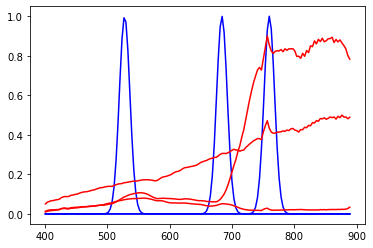

In [23]:
set_3 = filter_response(opti_wavelength,opti_bw)

plot(wavelength, set_3.T,'b')
plot(wavelength, spectra.T,'r')

In [24]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))

    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube, wavelength

In [25]:
def generate_correlation_matrix(hypercube, filter_responses, wavelength, verbose=False):
    '''
    Function to generate the correlation matrix between different
    channels in the MSFA. Computes the correlation between the central 
    wavelengths of each filter for every unique spectral response
    found in the target. Then, takes a weighted average of these
    correlations depending on how prevalent the particular spectral
    response is. Correlation matrix should be calculated before
    noise is added to the system.
    
    Inputs:
        hypercube (N x M x Q) - 3D synthetic hypercube.
        
        filter_responses (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
            filter in the MSFA. A total of J different filter responses of the macropixel
            should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
            e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube. Filter spectral responses must also be provided on this axis.
        
        verbose (optional Boolean, default=False) - Set to true to get updates on processing
        
    Outputs:
        corr (J x J) - Correlation matrix between central wavelengths 
    '''
    
    # Normalize spectral data per pixel to 
    N,M,Q = hypercube.shape
    hsi_norm = hypercube.max(axis=2)
    hsi_norm[hsi_norm==0] = 1.

    responses = []
    num_responses = []

    for i in range(N):
        if verbose and not i%100:
            print('Processing Row %d' %i)
        for j in range(M):
            norm_sig = hypercube[i,j]/hsi_norm[i,j]
            index_array = [all(norm_sig == resp) for resp in responses]
            if any(index_array):
                num_responses[argmax(index_array)]+=1
                continue
            else:
                responses.append(norm_sig)
                num_responses.append(1)
                
    filter_maxima = [argmax(f) for f in filter_responses]

    m_sigs = []
    for r in responses:
        max_signal = r[filter_maxima]
        m_sigs.append(max_signal)
        
    covariance = cov(m_sigs, fweights = num_responses, rowvar=False)
    
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [26]:
def generate_filter_data(filter_info, wavelength):
    '''
    Converts data from saved filter information (band locations, bandwidths, peak transmissions)
    into gaussian filter responses over a wavelength array.
    
    Inputs
        filter_info (L x 3 array): Saved filter information array in the form of (cw, bws, trans)
            where cw is Center Wavlength, bws is bandwidths, and trans is peak transmission.
    
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
            
    Outputs
        filter_data (L x Q array) - Array of filter responses over the wavelength array.
    '''
    L,_ = filter_info.shape
    Q = len(wavelength)
    
    filter_data = zeros((L,Q))
    
    for i in range(L):
        cw, bw, t = filter_info[i]
        sigma = bw / 2.355 # Convert from FWHM to sigma
        filter_data[i] = exp(-(wavelength - cw)**2/(2*sigma**2))*t
    
    return filter_data

In [27]:
def sample_hypercube_MSFA(hypercube, pattern_dims, filter_responses, wavelength, full_res=False):
    '''
    Generate raw MSFA data from a synthetic hypercube.
    
    Inputs:
        hypercube (N x M x Q) - 3D synthetic hypercube.
        
        pattern_dims ((mx, my)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
            provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.
        
        filter_responses (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
            filter in the MSFA. A total of J different filter responses of the macropixel
            should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
            e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube. Filter spectral responses must also be provided on this axis.
            
        full_res (optional Boolean) - Set to true to generate a reference image with no spatial sampling
            effects from the MSFA pattern pixellation. Use to generate "perfect" spatial image.
    
    Outputs:
        raw_MSFA (N x M x J) - Series of 2D images showing the collected signal for
            a given channel.
    '''
    mx,my = pattern_dims
    N,M,Q = hypercube.shape
    J = filter_responses.shape[0]
    
    if not mx*my == J:
        print('The filter response array does not have the correct number of members')
        return
    
    raw_MSFA = zeros((N,M,J))
    n = 0
    for i in range(mx):
        for j in range(my):
            
            MSFA = zeros((N,M))
            filter_response = filter_responses[n]
            
            
            if full_res:
                MSFA = sum(hypercube*filter_response,axis=2)
            else:
                MSFA[j::my,i::mx] = sum(hypercube[j::my,i::mx,:]*filter_response,axis=2)
            
            raw_MSFA[:,:,n] = MSFA
            
            n+=1

    return raw_MSFA, wavelength

In [28]:
def compute_H(mx,my):
    '''
    Caclulates the bilinear interpolation filter for a given mosaic.
    
    Inputs:
        mx -  Horizontal array dimension of MSFA macro-pixel.
        
        my - Vertical array dimension of MSFA macro-pixel.
        
    Outputs:
        H (mx*2-1 x my*2-1) - Weighted, normalized bilinear interpolation filter.
    '''

    # Initialize empty array
    H = zeros((int(my)*2-1,int(mx)*2-1))
    
    # Define un-normalized filter
    for i in range(my+1):
        H[i] = r_[arange(1,mx+1),arange(1,mx)[::-1]]*(i+1)

    for i in range(my):
        H[my*2-2-i] = r_[arange(1,mx+1),arange(1,mx)[::-1]]*(i+1)
        
    # Normalize
    H /= H.max()
        
    return H

In [29]:
def WB(I,H):
    '''
    Weighted bilinear interpolation.
    
    Inputs: 
        I (N x M array) - Individual channel image from MSFA
        
        H (2D array) - Weighted, normalized bilinear interpolation filter. Calculated from 
            mosaic dimensions
        
    Outputs:
        I_wb - Interpolated channel image.
        
    '''
    I_wb = convolve2d(I,H,mode='same')
    return I_wb

In [30]:
def binary_mask_MSFA(N,M,mx,my,L):
    '''
    Function to create binary mask corresponding to "observed" pixels
    in a MSFA channel.
    
    Inputs: 
        N,M - MSFA image data dimensions
        
        mx -  Horizontal array dimension of MSFA macro-pixel.
        
        my - Vertical array dimension of MSFA macro-pixel.
        
        L - Filter number (reading order)
    
    Outputs:
        mask (N,M) - Binary mask for observed pixels of a given channel.
    '''
    # This is not very elegant...
    output = zeros((N,M))
    
    n = 0
    for i in range(mx):
        for j in range(my):
            if n == L:
                output[j::my,i::mx] = 1.
                return output
            else:
                n+=1

In [31]:
# Iterative spectral differences
def ISB(I, pattern_dims, corr, iteration=0,verbose=False):
    '''
    Iterative spectral differences algorithm for demosaicking.
    
    Inputs:
        I (N x M x J array) - MSFA raw data array with J different channels. 
        
        pattern_dims ((mx, my)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
                provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.
        
        corr (J x J array) - Correlation matrix describing spectral correlation
            between each filter. Used to determine maximum number of iterations
        
        iteration (int, default=0) - Iteration number, tracked outside of function.
        
        verbose (optional Boolean) - Set to true for status updates. 
        
    Outputs:
        demosaicked (N x M x L array) - Demosaicked MSFA data
    
    '''
    if verbose and not iteration % 10:
        print("Iteration %d" % iteration)
    
    N,M,channels = I.shape
    mx,my = pattern_dims
    
    Nab = exp(corr*3.) # Compute iterations per channel pair
    
    demosaicked = zeros_like(I)
    
    H = compute_H(mx,my)
    
    # Reference - ch1
    for ch1 in range(channels):
        B1 = binary_mask_MSFA(N,M,mx,my,ch1)
        
        # Set output data to observed 
        demosaicked[:,:,ch1][B1==1.] = I[:,:,ch1][B1==1.]
        # Target - ch2
        for ch2 in range(channels):
            if ch1==ch2 or Nab[ch1,ch2]<=iteration:
                continue
            else:
                B2 = binary_mask_MSFA(N,M,mx,my,ch2)
                
                # Demosaicked channel A
                if iteration==0:
                    Ca = WB(I[:,:,ch1],H)
                else:
                    Ca = I[:,:,ch1]
                # Apply binary mask for target B
                # Subtract from observed to get difference
                # Apply bilinear interpolation
                Kab = WB(Ca*B2 - I[:,:,ch2]*B2,H)
                
                # 
                demosaicked[:,:,ch2][B1==1.] = (Ca - Kab)[B1==1.]

    return demosaicked

In [32]:
class ColourSystem:
    """A class representing a colour system.
    
    Assume pure white, illuminant E

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    reference: http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html

    """
    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))
    wv = arange(380,785,5)
                         
    def __init__(self, wavelength):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.
        
        If wavelength is provided, then the CMF function will be re-scaled
        to be on the same sampling as the provided array.

        """

        # Chromaticities
        # The chromaticity matrix (RGB -> XYZ) and its inverse (XYZ -> RGB)
        # Illuminant 'E'
        self.M = array([[0.4887180,0.3106803,0.2006017],[0.1762044,0.8129847,0.0108109],[0.0000000,  0.0102048, 0.9897952]])
        self.MI = np.linalg.inv(self.M)

        self.cmf = array([interp(wavelength, self.wv, self.cmf[:,0]),
                          interp(wavelength, self.wv, self.cmf[:,1]),
                          interp(wavelength, self.wv, self.cmf[:,2])]).T
        
        self.wv = wavelength        
        self.N = np.sum(self.cmf[:,1] * ones((len(self.wv),)))

    def xyz_to_rgb(self, xyz):
        """
        Transform from xyz to rgb representation of colour.
        """
        rgb = self.MI.dot(xyz)
        
        # We're not in the RGB gamut: approximate by desaturating
        rgb[rgb<0] = 0
        rgb[rgb>1] = 1

        return rgb

    def spec_to_xyz(self, spec):
        """
        Convert a spectrum to an xyz point.
        """
        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        return XYZ / self.N

    def spec_to_rgb(self, spec):
        """Convert a spectrum to an rgb value."""
        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz)

In [33]:
def MSFA_to_RGB(MSFA, filters, wavelength, verbose=False):
    '''
    Convert demosaicked MSFA data to RGB spectra using filter responses to
    represent complete spectra.
    
    Inputs:
    
        MSFA (N x M x J) - MSFA demosaiced data array with J channels / filters. 
        
        filters (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
            filter in the MSFA. A total of J different filter responses of the macropixel
            should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
            e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
        
        wavelength (Q x 1) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube. Filter spectral responses must also be provided on this axis.
        
        cs - ColorSystem object defining RGB colorspace
        
        verbose (optional) - Set to true for status updates.
    
    Outputs: 
        MSFA_RGB (N x M x 3 array) - RGB-equivalent image generated from MSFA data
    
    '''
    px,py,channels = MSFA.shape
    
    print('channel shape',MSFA.shape)
    print('filter shape',filters.shape)
    
    cs = ColourSystem(wavelength)
    
    MSFA_RGB = zeros((px,py,3))
    
    # Can we do this with an array operation to speed up the 
    # processing?
    
    for j in range(py):
        if verbose and not j % 100:
            print("Converting row %d" %j)
        for i in range(px):
            spectra = zeros_like(filters[0])
            spectra = spectra.astype(np.float64)

            for c in range(0,int(channels-1)):
                #print('c',c)
                spectra += MSFA[j,i,c]*filters[c]
                
            MSFA_RGB[j,i,:] = cs.spec_to_rgb(spectra)
            
    return MSFA_RGB

In [34]:
def hypercube_to_RGB(hypercube,wavelength,verbose=False):
    '''
    Convert hyperspectral data to RGB
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.    
            
        cs - ColorSystem object defining RGB colorspace
        
    Outputs:
        hypercube_RGB (N x M x 3) - RGB-equivalent image generated from hyperspectral data.
    
    '''
    px,py,wv = hypercube.shape
    
    hypercube_RGB = zeros((px,py,3))
    
    cs = ColourSystem(wavelength)
    
    # Can we do this with an array operation to speed up the 
    # processing?
    
    for j in range(py):
        if verbose and not j % 100:
            print("Converting row %d" %j)
        for i in range(px):
            hypercube_RGB[j,i,:] = cs.spec_to_rgb(hypercube[j,i])
            
    return hypercube_RGB

In [35]:
def RMS_pixel_difference(im,ref):
    '''
    Total RMS error between an image (im) and reference (ref). Used as a merit function.
    
    Inputs:
        im (N x M array) - Image to test quality.
    
        ref (M x M array) - Reference to compare test image to.
    
    Outputs:
    
        rms (float): RMS pixel difference between input image and a reference.
    
    '''
    
    # How to account for scaling between channels?
    d = im / im.max(axis=(0,1))
    rms = sqrt( mean((d-ref)**2) )
        
    return rms

In [36]:
from scipy.fft import fft, ifft
import numpy as np

def DFT_difference(im,ref):
    '''
    Merit function option to compute difference between two images
    in fourier space using discrete fourier transform.
    
        Inputs:
        im (N x M array) - Image to test quality.
    
        ref (M x M array) - Reference to compare test image to.
    
    Outputs:
    
        dft_diff (float): 
    
    
    '''
    # TO DO: Write this function
    # How to account for scaling between channels?
    d = im / im.max(axis=(0,1))
    xf = fft(im)
    yf = fft(ref)
    
    dft_diff = sqrt(mean((np.real(yf-xf))**2))
    
    return dft_diff

In [37]:
def generate_duplication(pattern_dims,hypercube,opti_bw, opti_wavelength,wavelength,transmissivity, verbose=False):
    
    '''
    Inputs:
        1) hypercube (N X M x Q) - 3D synthetic hypercube.
        2) bandwidth
        3) wavelength
        4) number of block (mxXny)
        
    Output:
         f_filter that matched with number of block in the pattern (blocks, wavlength region)
         
    Could be improve:
       ranking way
    '''
    ranked_table = intensity_rank(hypercube,opti_bw, opti_wavelength,wavelength,transmissivity,verbose=False)
    filter_number,_ = ranked_table.shape
    print('filter_number',filter_number)

    X,Y = pattern_dims
    number_of_block = X*Y
    print('number_of_block',number_of_block)
    
    W = wavelength.shape[0]
    f = zeros((number_of_block,int(W)))
    filter_labels = zeros((number_of_block))
    
    if filter_number > number_of_block:
        # use top intensity 
        for i in range(0,(number_of_block)):
            print(i)
            # pick from high intensity
            number = filter_number-1-i
            print(number)
            opti_wavelength = ranked_table[number,0]
            opti_bw = ranked_table[number,1]
            print(opti_wavelength)
            f[i] = exp(-(wavelength - opti_wavelength)**2 / (2*(opti_bw/2.355)**2))
            filter_labels[i] = opti_wavelength

    else:
        # need duplicate
        for i in range(0,(number_of_block)):
            # pick from high intensity
            number = filter_number-i-1
            if number >= 0:
                number = number
                opti_wavelength = ranked_table[number,0]
                opti_bw = ranked_table[number,1]
                f[i] = exp(-(wavelength - opti_wavelength)**2 / (2*(opti_bw/2.355)**2))
                filter_labels[i] = opti_wavelength
                print('No',number)
                print('opti_wave',opti_wavelength)
            else:
                number = filter_number - abs(number)
                opti_wavelength = ranked_table[number,0]
                opti_bw = ranked_table[number,1]
                f[i] = exp(-(wavelength - opti_wavelength)**2 / (2*(opti_bw/2.355)**2))
                filter_labels[i] = opti_wavelength
                print('No',number)
                print('opti_wave',opti_wavelength)
            #print('filter',number)
    #print("filters respond shape:", f.shape)

        
    return f, filter_labels

In [38]:
def cross_area_matrix(hypercube, opti_bw, opti_wavelength, wavelength, verbose=False):
    
    '''
    Inputs:
        1) hypercube (N X M x Q) - 3D synthetic hypercube.
        2) filter_responses (Q X P) - P is the number of filters.
        3) wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    
    Output:
        correlation_relation depends on three factor: 
        1) Total area of each filter 
        2) Cross area of arbitary two filter
        3) The total intensity recieved by this chanel 
        
    Could be improve:
        1) the weight bwtween this three factors
        2) the normalize method while dealing with the 'total intensity' given by the hypercube
        
    '''
    # preparation
    filter_number = len(opti_wavelength)
    N,M,Q = hypercube.shape
    hypercube = hypercube.reshape(N*M,Q)
    print('hypercube shape',hypercube.shape)
    Intensity_recieved = zeros((N*M,Q))
    #number_of_filter 
    L = len(opti_wavelength)
    filters = []
    
    #matrxi for wavelength and bw, intensity, ranked by intensity
    matrix = zeros((L,3))
    matrix[:,0] = opti_wavelength
    matrix[:,1] = opti_bw

    # Define filter responses, add them together, not a elegant way, should improve it later
    filters = [exp(-(wavelength - opti_wavelength[i])**2 / (2*(opti_bw[i]/2.355)**2)) for i in range(len(opti_wavelength))]
    filter_responses = np.array(filters)
    filter_responses = filter_responses.T
   
    print('filter_response shape',filter_responses.shape)

    K,P = filter_responses.shape
    cross_area = zeros((P,P))
    hyper = zeros((K,P))
    
    # Normalize spectral data per pixel, use mean of the intensity to normalized it
    hyper_combine_filter = []
    hsi_norm = hypercube.mean(axis=0)
    hsi_norm[hsi_norm==0] = 1.
    
    print(hsi_norm.shape)
    
    #introduce this factor to filter
    for n in range(K):
        for m in range(P):
            hyper[n,m]=np.vdot(hsi_norm[n],filter_responses[n,m])
    
    # Normalize spectral data per pixel, use mean of the intensity to normalized it
    hyper_combine_filter = []
    hsi_norm = hypercube.mean(axis=0)
    hsi_norm[hsi_norm==0] = 1.
    
    
    #introduce this factor to filter
    for n in range(K):
        for m in range(P):
            hyper[n,m]=np.vdot(hsi_norm[n],filter_responses[n,m])
        
    print(hyper.shape)
    # calculate the cross area for each filters, 
    # the diagonal provides the information of the height of this filter,somehow provide the information of total area

    
    #  Give weight bwtween these factors
    # here just multiply them together
    filter_responses = hyper
    
    for i in range(P):
        for j in range(P):
            if i != j:
                cross_area[i,j]= np.vdot(filter_responses[:,i],filter_responses[:,j])
            else :
                cross_area[i,i] = 0
    #print(cross_area)
    
            
    
    return abs(cross_area)

In [39]:
def spatial_optimization_MSFA(hypercube,wavelength,pattern_dims, opti_bw, opti_wavelength,transmissivity, demosaicking='ISB',op_type='exhaustive', merit_function='RMS',verbose=True,drop_dignal=False,speed_up = True):
        '''
        Full spatial optimization pipeline to determine the optimal filter
        pattern for a multispectral filter array given a synthetic hypercube
        target, and filter responses.
        
        Inputs:
            hypercube (N X M x Q) - 3D synthetic hypercube.
            
            wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
                response arrays.
            
            pattern_dims ((mx, my)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
                provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.

            filters (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
                filter in the MSFA. A total of J different filter responses of the macropixel
                should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
                e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.

            filter_labels (optional J x 1 List): List of labels for each filter
            
            demosaicking (optional): 
                'ISB' - Iterative spectral differences (default) 
                'WB' - Weighted bi-linear interpolation
        
            op_type (optional): Type of optimization.
                'exhaustive' - test every possible spatial arrangement
        
            merit_function (optional):
                'RMS' - Computes RMS pixel differences between (default)
                'RMS-RGB' - Computes RMS pixel differences between
                'DFT'
                'DFT-RGB'
            
            verbose (optional): Set to true for status updates
            
        Outputs:
            pattern
        '''
        
        filter_number = len(opti_wavelength)
        print('wavelenght',wavelength.shape)
        
        # generate duplication
        filters,filter_labels = generate_duplication(pattern_dims,hypercube,opti_bw, opti_wavelength,wavelength,transmissivity, verbose=False)
        print('filter label ranked by intensity',filter_labels)
       
        X,Y = pattern_dims
        number_of_block = X*Y
    
        if drop_dignal == True:  
            print('fixed diagnol element by largest cross area')
            cross_area = cross_area_matrix(hypercube,opti_bw, opti_wavelength, wavelength, verbose=False)
            print('cross area matrix. shape',cross_area.shape)
            #find the two filters with biggest cross area, then put them in diagonal
            max_cross_area = np.max(cross_area)
            location = np.where(cross_area ==np.max(max_cross_area))
            # find the position of these two filter 
            lo = zeros((4))
            s = 0
            for n in location:
                for m in n:
                    lo[s] = m
                    s += 1       
            #print(lo)
            diag1 = int(lo[0])
            diag2 = int(lo[1])
            print('diagnol two are filter No.', diag1,'and', diag2, "with centre wavelength",opti_wavelength[diag1],'and',opti_wavelength[diag2])

            # drop 2 diagnoal filter 
            loc1 = np.where(filter_labels ==opti_wavelength[diag1])
            loc2 = np.where(filter_labels ==opti_wavelength[diag2])
            print('check',opti_wavelength[diag2])
            print('check',loc2)
            for q in loc1:
                for x in q:
                    pos1 = int(x)
                    print('pos1:',pos1,"with centre wavelength",opti_wavelength[diag1])
            for y in loc2:
                for z in y:
                    if int(z) < filter_number:
                        pos2 = int(z)
                        print('pos2:',pos2,"with centre wavelength",opti_wavelength[diag2])

            if pos2 > pos1:
                filters_s = np.delete(filters,pos1,0)
                filters_s = np.delete(filters_s,int(pos2 - 1),0)
            else:
                filters_s = np.delete(filters,pos1,0)
                filters_s = np.delete(filters_s,int(pos2 - 1),0)

            f1 = filters[pos1]
            f2 = filters[pos2]

            print('after delete 2 diagnal filter. shape',filters_s.shape)
            N_filters,_ = filters_s.shape
            
        else:
            N_filters,_ = filters.shape
            
        #corr = generate_correlation_matrix(hypercube,filters,wavelength)
        #print('generating correlation matrix, shape:', corr.shape)
        # Iterate through every possible permutation of the filter arrangement
        
        # Iterate through every possible permutation of the filter arrangement
        if op_type == 'exhaustive':
            best = inf
            pattern = []
            best_demosaicked = None
            results = []
            pattern_labels = []
            
            # to speed up in order to get rid of symmtry
            if pattern_dims == (2,2) and speed_up == True:
                fil_set_pool = [(0,1,2,3),(0,3,1,2),(0,3,2,1)]
                    
               
            elif drop_dignal == True:   
                    # count the number of available choices
                    H=0
                    for fil_set in permutations(arange(N_filters), N_filters):
                        H +=1
                    print('number of choice',H)
                    
                    
                    i = 0
                    for fil_set in permutations(arange(N_filters), N_filters):
                        print('set',fil_set)
                        fil_set = np.insert(fil_set,0,diag1)
                        fil_set = np.insert(fil_set,H+1,diag2)
                        print(fil_set)
                        if i == 0:
                            fil_set_pool = fil_set
                        else:
                            fil_set_pool = [fil_set_pool,fil_set]
                        i = i+1    
            
            else: 
                fil_set_pool = permutations(arange(N_filters), N_filters)
                
            for fil_set in fil_set_pool:
                
                f = array([filters[i] for i in fil_set])
                # Generate raw MSFA data
                raw, _ = sample_hypercube_MSFA(hypercube,pattern_dims,f,wavelength)
                
                # Generate perfect spatial reference
                ref,_ = sample_hypercube_MSFA(hypercube,pattern_dims,f,wavelength,full_res=True)
                
                # Demosaic the raw MSFA data using iterative spectral differences
                if demosaicking == "WB":
                    if verbose:
                        print("Using weighted bilinear interpolation for demosaicking.")
                    H = compute_H(*pattern_dims)
                    demosaicked = zeros_like(raw)
                    for c in range(len(f)):
                        demosaicked[:,:,c] = WB(raw[:,:,c],H)
                else:
                    if verbose:
                        print("Using iterative spectral differences with %i iterations" %int(exp(corr.max()*3.)))
                    for iteration in range(int(exp(corr.max()*3.))):
                        demosaicked = ISB(raw,pattern_dims, corr, iteration=iteration,verbose=verbose)
                
                if merit_function == 'RMS-RGB':
                    demosaicked_RGB = MSFA_to_RGB(demosaicked, f, wavelength)
                    ref_RGB = hypercube_to_RGB(hypercube,wavelength)
                    m = RMS_pixel_difference(demosaicked_RGB, ref_RGB)
                    print('RMS-RGB')
                
                elif merit_function == 'DFT':
                    m = DFT_difference(demosaicked, ref)
                    demosaicked_RGB = demosaicked
                    print('DFT')
                    
                elif merit_function == 'DFT-RGB':
                    demosaicked_RGB = MSFA_to_RGB(demosaicked, f, wavelength)
                    ref_RGB = hypercube_to_RGB(hypercube,wavelength)
                    m = DFT_difference(demosaicked_RGB, ref_RGB)
                    print('DFT-RGB')
                    
                else: # Default
                    m = RMS_pixel_difference(demosaicked, ref)
                    demosaicked_RGB = demosaicked
                    print('RMS')
                    
                results.append(m)
                
                if m < best:
                    best = m
                    pattern = fil_set
                    best_demosaicked = demosaicked
                    pattern_labels = [filter_labels[i] for i in fil_set]
                    
                if verbose:
                    print("Using pattern (reading order) of ", [filter_labels[i] for i in fil_set], "gives merit function result of", results[-1])
        else:
            print("Optimizations other than exhaustive are not yet supported.")
            return False

        
        return pattern, pattern_labels, demosaicked,demosaicked_RGB

In [40]:
from pysptools import abundance_maps

def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    print('acc = ',accuracy)
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy,predicted.reshape((N,M,P))

In [57]:
def compute_unmixing_accuracy_demosaicked(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths,demosaicked, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    demosaicked = demosaicked.reshape((N*M,P))
    
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = demosaicked[:,i]
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
   
    print('pic',len(endmember_sig))
    truth = abundance_map.reshape((N*M,len(endmember_sig)))
  
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    #print(truth.shape)
    #print(predicted.shape)
    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((truth-predicted)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

# Start optimization

# High intensity duplication

In [47]:
opti_wavelength = [528, 684, 760,760]

In [52]:
opti_bw = [20,20,20,20]

In [49]:
transmissivity = [1,1,1,1]

In [50]:
pattern_dims = (2,2)

In [54]:
hypercube.shape

(95, 95, 156)

In [53]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='RMS',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 760.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [760. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 760.0, 684.0, 528.0] gives merit function result of 1.5633348444267656
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 760.0, 528.0, 684.0] gives merit function result of 1.563803977013893
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 684.0, 760.0, 528.0] gives merit function result of 1.5557608110031742
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 684.0, 528.0, 760.0] gives merit function result of 1.560072084413457
Using weighted bilinear interpolation for demosaicking.
RMS
Using

In [55]:
best_pattern_labels

[760.0, 684.0, 760.0, 528.0]

In [56]:
best_pattern

(0, 2, 1, 3)

In [60]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='RMS_RGB',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)
print(best_pattern_labels)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 760.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [760. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 760.0, 684.0, 528.0] gives merit function result of 1.5633348444267656
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 760.0, 528.0, 684.0] gives merit function result of 1.563803977013893
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 684.0, 760.0, 528.0] gives merit function result of 1.5557608110031742
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [760.0, 684.0, 528.0, 760.0] gives merit function result of 1.560072084413457
Using weighted bilinear interpolation for demosaicking.
RMS
Using

In [61]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='DFT',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)
print(best_pattern_labels)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 760.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [760. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [760.0, 760.0, 684.0, 528.0] gives merit function result of 0.2746920442005958
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [760.0, 760.0, 528.0, 684.0] gives merit function result of 0.27830830087520236
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [760.0, 684.0, 760.0, 528.0] gives merit function result of 0.29912381083647954
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [760.0, 684.0, 528.0, 760.0] gives merit function result of 0.2928353014237182
Using weighted bilinear interpolation for demosaicking.
DFT
U

# Lower intensity

In [62]:
opti_wavelength = [528, 684, 760,528]

In [63]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='RMS',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 528.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [528. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 760.0, 684.0, 528.0] gives merit function result of 1.1471816299147986
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 760.0, 528.0, 684.0] gives merit function result of 1.1478208635233909
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 684.0, 760.0, 528.0] gives merit function result of 1.1368384042019204
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 684.0, 528.0, 760.0] gives merit function result of 1.142731274089085
Using weighted bilinear interpolation for demosaicking.
RMS
Usin

In [64]:
best_pattern_labels

[684.0, 528.0, 760.0, 528.0]

In [65]:
best_pattern

(2, 0, 1, 3)

In [66]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='RMS_RGB',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)
print(best_pattern_labels)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 528.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [528. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 760.0, 684.0, 528.0] gives merit function result of 1.1471816299147986
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 760.0, 528.0, 684.0] gives merit function result of 1.1478208635233909
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 684.0, 760.0, 528.0] gives merit function result of 1.1368384042019204
Using weighted bilinear interpolation for demosaicking.
RMS
Using pattern (reading order) of  [528.0, 684.0, 528.0, 760.0] gives merit function result of 1.142731274089085
Using weighted bilinear interpolation for demosaicking.
RMS
Usin

In [67]:
start = time.time()
best_pattern,best_pattern_labels, demosaicked,demosaicked_RGB = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,opti_bw,opti_wavelength,transmissivity,demosaicking ='WB', merit_function='DFT',drop_dignal=False,speed_up = False)
end = time.time()
print('time cost(in seconds)',end-start)
print(best_pattern_labels)

wavelenght (156,)
hypercube shape (9025, 156)
4
number of filter type 4
filter_number 4
number_of_block 4
No 3
opti_wave 528.0
No 2
opti_wave 760.0
No 1
opti_wave 684.0
No 0
opti_wave 528.0
filter label ranked by intensity [528. 760. 684. 528.]
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [528.0, 760.0, 684.0, 528.0] gives merit function result of 0.22755880441436804
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [528.0, 760.0, 528.0, 684.0] gives merit function result of 0.2319111913113222
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [528.0, 684.0, 760.0, 528.0] gives merit function result of 0.2565196766892016
Using weighted bilinear interpolation for demosaicking.
DFT
Using pattern (reading order) of  [528.0, 684.0, 528.0, 760.0] gives merit function result of 0.24915819087341773
Using weighted bilinear interpolation for demosaicking.
DFT
U

Need to point out, here I just linearly add two image together and average out to give the img for the color with duplication, it should have other better way to implement it.

<ipython-input-68-fb911dae2fa8>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(2,2,3)


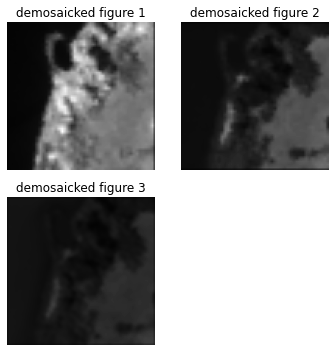

In [68]:
plt.rcParams['figure.figsize'] = [5, 5]

subplot(2,2,1)
plt.imshow(demosaicked[:,:,2],cmap=cm.gray,vmin=0,vmax=demosaicked.max())
axis("off")
title('demosaicked figure 1')
subplot(2,2,2)
plt.imshow(demosaicked[:,:,1],cmap=cm.gray,vmin=0,vmax=demosaicked.max())
axis("off")
title('demosaicked figure 2')
subplot(2,2,3)
#plt.imshow(demosaicked[:,:,2],cmap=cm.gray,vmin=0,vmax=demosaicked.max())
#axis("off")
subplot(2,2,3)
plt.imshow((demosaicked[:,:,0]+demosaicked[:,:,3])/2,cmap=cm.gray,vmin=0,vmax=demosaicked.max())
axis("off")
title('demosaicked figure 3')

tight_layout()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.imshow(demosaicked_RGB,vmin=0,vmax=demosaicked_RGB.max())
axis("off")
title('demosaicked_RGB')


tight_layout()

# Start unmixing to find the abundance map

In [ ]:
opti_wavelength = [528, 684, 760,528]
opti_bw = [20,20,20,20]

In [ ]:

# Extract relevant dimensions
N,M,Q = hypercube.shape
    
# Define filter responses
filters = [exp(-(wavelength - opti_wavelength[i])**2 / (2*(opti_bw[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
P = len(endmembers)
L = len(filters)
    
# Pre-allocate arrays
data_sig = zeros((N*M,L))
endmember_sig = zeros((P,L))
demosaicked = demosaicked.reshape((N*M,P))
    
    
# Iterate through each filter
for i,f in enumerate(filters):
    # Compute the signal from each filter received from the data
    # and that received from an endmember.
    data_sig[:,i] = demosaicked[:,i]
        
    for j, e in enumerate(endmembers):
        endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
   
    
truth = abundance_map.reshape((N*M,len(endmember_sig)))
  
# Reshape the data array into 1d array
predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

#print(truth.shape)
#print(predicted.shape)
# Take RMS difference between true abundance map and computed.
accuracy = sqrt(mean((truth-predicted)**2))
    
